# Data visualization and pre-processing

## Data visualization

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pyarrow.parquet as pq
import polars as pl

In [93]:
train_events = pd.read_csv('../../train_events.csv')

#Read file with chunks
#chunksize = 100000
#train_series = pq.ParquetFile('../../train_series.parquet')
#for batch in train_series.iter_batches(batch_size=chunksize):
#    train_series_chunk = batch.to_pandas()

train_series = pd.read_csv('../../filtered_train_series.csv')

test_series = pq.read_table('../../test_series.parquet').to_pandas()

### Train events visualization

In [94]:
train_events

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
...,...,...,...,...,...
14503,fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400
14504,fe90110788d2,34,onset,574620.0,2017-09-06T23:35:00-0400
14505,fe90110788d2,34,wakeup,581604.0,2017-09-07T09:17:00-0400
14506,fe90110788d2,35,onset,NaN,NaN


In [95]:
# Calculer le nombre de valeurs NaN par colonne
nan_counts = train_events.isna().sum()

# Afficher le résultat
print(f"Nombre de valeurs manquantes par colones:\n{nan_counts}")


Nombre de valeurs manquantes par colones:
series_id       0
night           0
event           0
step         4923
timestamp    4923
dtype: int64


In [96]:
train_events = train_events.dropna(subset=['timestamp'])

# Calculer le nombre de valeurs NaN par colonne
nan_counts = train_events.isna().sum()

# Afficher le résultat
print(f"Nombre de valeurs manquantes par colones:\n{nan_counts}")

Nombre de valeurs manquantes par colones:
series_id    0
night        0
event        0
step         0
timestamp    0
dtype: int64


In [97]:
num_duplicates = train_events.duplicated().sum()
print(f"Nombre de lignes dupliquées : {num_duplicates}")


Nombre de lignes dupliquées : 0


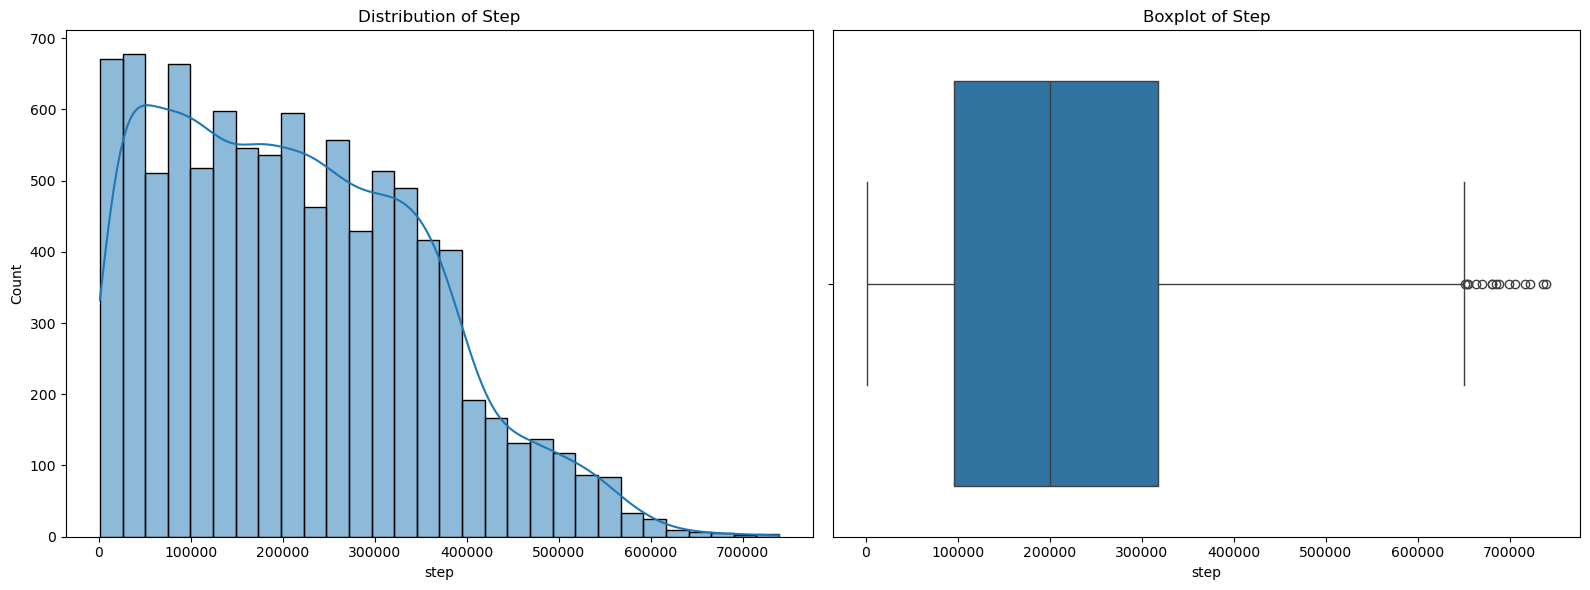

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 ligne, 2 colonnes

# Histogramme pour la colonne "step"
sns.histplot(train_events['step'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Step')

# Boxplot pour identifier les outliers
sns.boxplot(x=train_events['step'], ax=axes[1])
axes[1].set_title('Boxplot of Step')

# Afficher les graphiques
plt.tight_layout()
plt.show()


On observe une majorité d'événements qui se produisent pour des steps entre 0 et 400000. Puis après une très grosse baisse d'événements graduelle.

Le boxplot nous montre une médiane centrée sur 200000 steps. On remarque aussi quelques outliers à partir de 650000 steps.

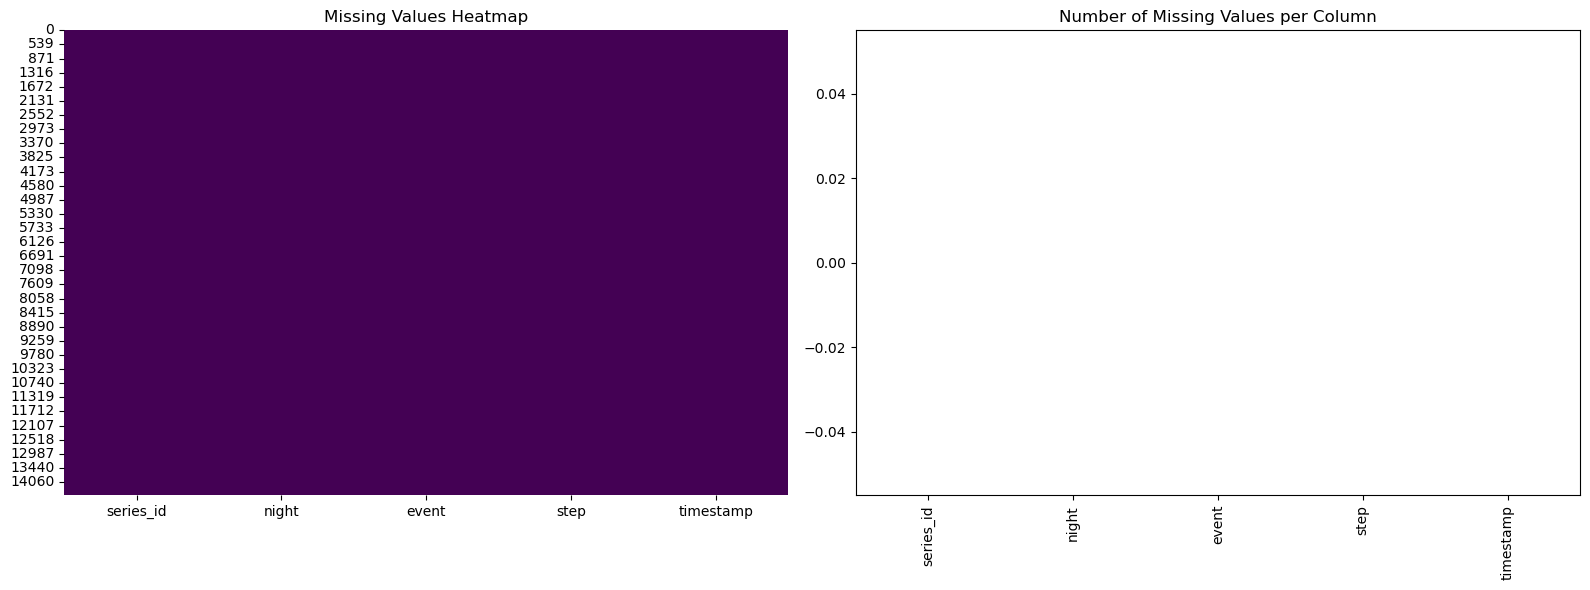

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Visualisation des valeurs manquantes (Heatmap)
sns.heatmap(train_events.isna(), cbar=False, cmap='viridis', ax=axes[0])
axes[0].set_title('Missing Values Heatmap')

# Nombre de valeurs NaN par colonne (Barplot)
train_events.isna().sum().plot(kind='bar', ax=axes[1])
axes[1].set_title('Number of Missing Values per Column')

# Afficher les graphiques
plt.tight_layout()
plt.show()


On voit que les valeurs manquantes sont seulements sur les colonnes step et timestamp (colonnes numériques). Les valeurs manquantes semblent être réparties uniformément dans tout le jeu de données selon la heatmap et aussi simultanement pour step et timestamp

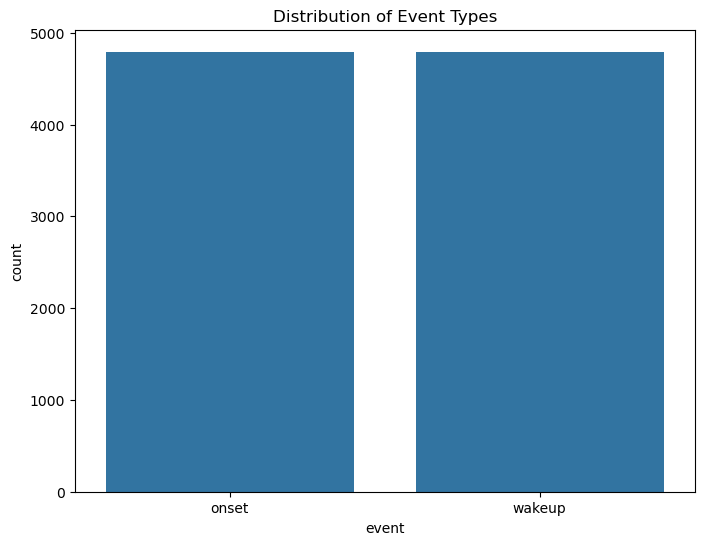

In [81]:
# Compter la fréquence des différents types d'événements
plt.figure(figsize=(8, 6))
sns.countplot(x='event', data=train_events)
plt.title('Distribution of Event Types')
plt.show()

IL y a autant d'événements onset que wakeup

/tmp/ipykernel_221409/1324955619.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], errors='coerce')
/tmp/ipykernel_221409/1324955619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], errors='coerce')


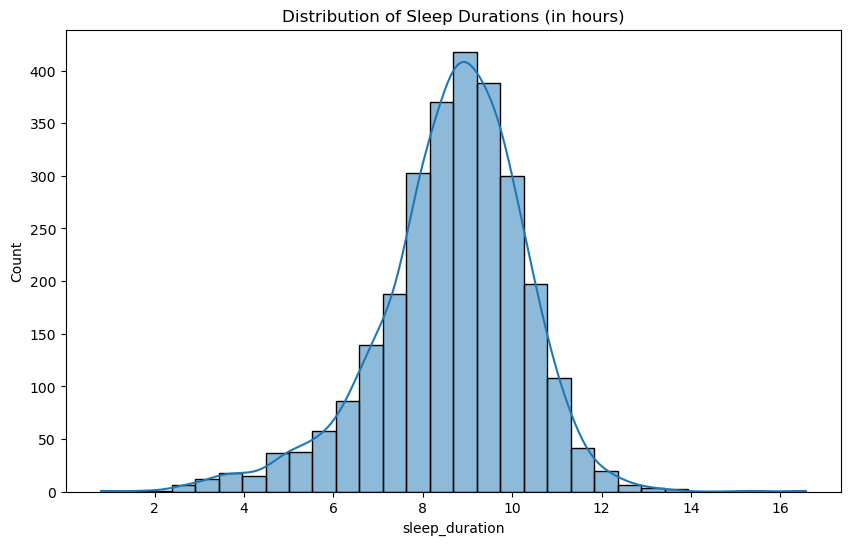

In [82]:
# Convertir les timestamps en datetime dans le DataFrame d'origine
train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], errors='coerce')

# Créer des DataFrames séparés pour les événements 'onset' et 'wakeup'
onset_df = train_events[train_events['event'] == 'onset']
wakeup_df = train_events[train_events['event'] == 'wakeup']

# Fusionner onset et wakeup sur 'series_id' et 'night' pour chaque nuit
sleep_durations = pd.merge(onset_df, wakeup_df, on=['series_id', 'night'], suffixes=('_onset', '_wakeup'))

# Assurer que les colonnes timestamp sont bien de type datetime
sleep_durations['timestamp_onset'] = pd.to_datetime(sleep_durations['timestamp_onset'], errors='coerce')
sleep_durations['timestamp_wakeup'] = pd.to_datetime(sleep_durations['timestamp_wakeup'], errors='coerce')

# Calculer la durée de chaque nuit en heures
sleep_durations['sleep_duration'] = (sleep_durations['timestamp_wakeup'] - sleep_durations['timestamp_onset']).dt.total_seconds() / 3600

# Visualisation des durées de sommeil
plt.figure(figsize=(10, 6))
sns.histplot(sleep_durations['sleep_duration'], bins=30, kde=True)
plt.title('Distribution of Sleep Durations (in hours)')
plt.show()



La durée de sommeil semble suivre une loi normale centrée autour de 9h de sommeil.

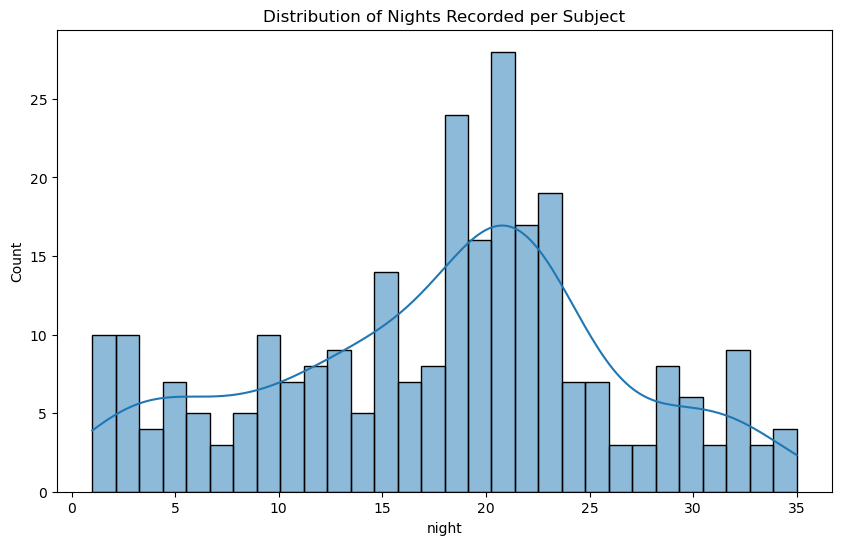

In [83]:
# Nombre de nuits par sujet
nights_per_subject = train_events.groupby('series_id')['night'].nunique()

plt.figure(figsize=(10, 6))
sns.histplot(nights_per_subject, bins=30, kde=True)
plt.title('Distribution of Nights Recorded per Subject')
plt.show()


Les sujets semblent faire en moyenne un peu plus entre 20 et 30 nuits.

In [102]:
# Convertir les timestamps en datetime, en remplaçant les valeurs non convertibles par NaT
train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], errors='coerce')

# Vérifier les valeurs NaT après conversion
print(train_events['timestamp'].isna().sum(), "valeurs NaT dans la colonne 'timestamp'")

# Supprimer les lignes avec NaT dans la colonne 'timestamp'
train_events = train_events.dropna(subset=['timestamp'])

# Vérifier les valeurs NaT après conversion
print(train_events['timestamp'].isna().sum(), "valeurs NaT dans la colonne 'timestamp'")

4043 valeurs NaT dans la colonne 'timestamp'
0 valeurs NaT dans la colonne 'timestamp'


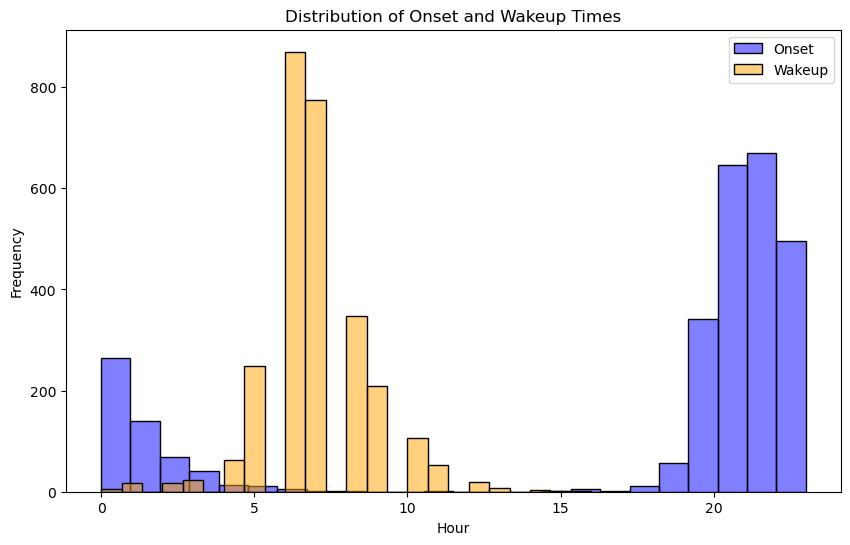

In [103]:
# Extraire l'heure des timestamps pour les événements onset et wakeup
train_events['hour'] = train_events['timestamp'].dt.hour

# Visualisation des heures d'onset et wakeup sans KDE
plt.figure(figsize=(10, 6))
sns.histplot(train_events[train_events['event'] == 'onset']['hour'], color='blue', label='Onset', kde=False, bins=24, alpha = 0.5)
sns.histplot(train_events[train_events['event'] == 'wakeup']['hour'], color='orange', label='Wakeup', kde=False, bins=24, alpha = 0.5)
plt.title('Distribution of Onset and Wakeup Times')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.legend()
plt.show()



In [89]:
# Convert the timestamp columns to datetime format
train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], format='%Y-%m-%dT%H:%M:%S%z', utc=True)

print(train_events.head())

      series_id  night   event     step                 timestamp  hour
0  038441c925bb      1   onset   4992.0 2018-08-15 02:26:00+00:00    22
1  038441c925bb      1  wakeup  10932.0 2018-08-15 10:41:00+00:00     6
2  038441c925bb      2   onset  20244.0 2018-08-15 23:37:00+00:00    19
3  038441c925bb      2  wakeup  27492.0 2018-08-16 09:41:00+00:00     5
4  038441c925bb      3   onset  39996.0 2018-08-17 03:03:00+00:00    23


In [90]:
# Separate onsets and wakeups
onsets = train_events[train_events['event'] == 'onset']
wakeups = train_events[train_events['event'] == 'wakeup']
times_onset = onsets['timestamp'].dt.time
times_wakeup = wakeups['timestamp'].dt.time

earliest_onset_time = min(times_onset)
latest_wakeup_time = max(times_wakeup)

print(f"Earliest onset: {earliest_onset_time}")
print(f"Latest wakeup: {latest_wakeup_time}")

Earliest onset: 00:00:00
Latest wakeup: 20:14:00


/tmp/ipykernel_221409/1234346508.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours_onset = onsets['timestamp'].dt.round('H').dt.hour
/tmp/ipykernel_221409/1234346508.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours_wakeup = wakeups['timestamp'].dt.round('H').dt.hour


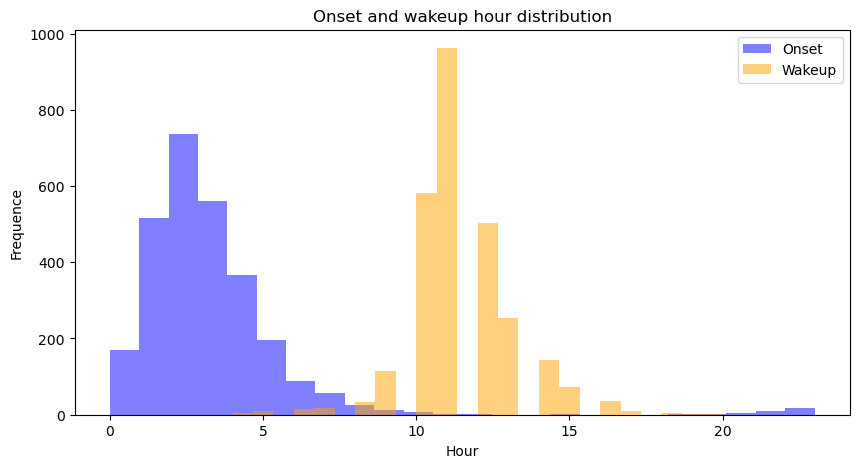

In [91]:
hours_onset = onsets['timestamp'].dt.round('H').dt.hour
hours_wakeup = wakeups['timestamp'].dt.round('H').dt.hour

# plot onset and wakeup time distribution
plt.figure(figsize=(10,5))
plt.hist(hours_onset, bins=24, alpha=0.5, label='Onset', color='blue')
plt.hist(hours_wakeup, bins=24, alpha=0.5, label='Wakeup', color='orange')

# Ajouter des légendes et des titres
plt.xlabel('Hour')
plt.ylabel('Frequence')
plt.title('Onset and wakeup hour distribution')
plt.legend()

# Afficher le plot
plt.show()

On distingue bien le contraste de distribution des temps d'onset et de Wakeup

### Train series visualization

In [14]:
train_series

,series_id,step,timestamp,anglez,enmo,event
0,038441c925bb,85,2018-08-14 19:37:05+00:00,-79.9769,0.0129,0
1,038441c925bb,123,2018-08-14 19:40:15+00:00,-80.2026,0.0129,0
2,038441c925bb,313,2018-08-14 19:56:05+00:00,-82.3155,0.0156,0
3,038441c925bb,333,2018-08-14 19:57:45+00:00,-82.3025,0.0142,0
4,038441c925bb,419,2018-08-14 20:04:55+00:00,-83.4873,0.0149,0
...,...,...,...,...,...,...
1288750,fe90110788d2,591647,2017-09-08 03:13:55+00:00,49.3486,0.0045,0
1288751,fe90110788d2,591776,2017-09-08 03:24:40+00:00,11.3838,0.0000,0
1288752,fe90110788d2,591817,2017-09-08 03:28:05+00:00,15.7196,0.0000,0
1288753,fe90110788d2,592189,2017-09-08 03:59:05+00:00,15.7196,0.0000,0


In [15]:
# Calculer le nombre de valeurs NaN par colonne
nan_counts = train_series.isna().sum()

# Afficher le résultat
print(f"Nombre de valeurs manquantes par colones:\n{nan_counts}")


Nombre de valeurs manquantes par colones:
series_id    0
step         0
timestamp    0
anglez       0
enmo         0
event        0
dtype: int64


In [16]:
num_duplicates = train_series.duplicated().sum()
print(f"Nombre de lignes dupliquées : {num_duplicates}")

Nombre de lignes dupliquées : 0


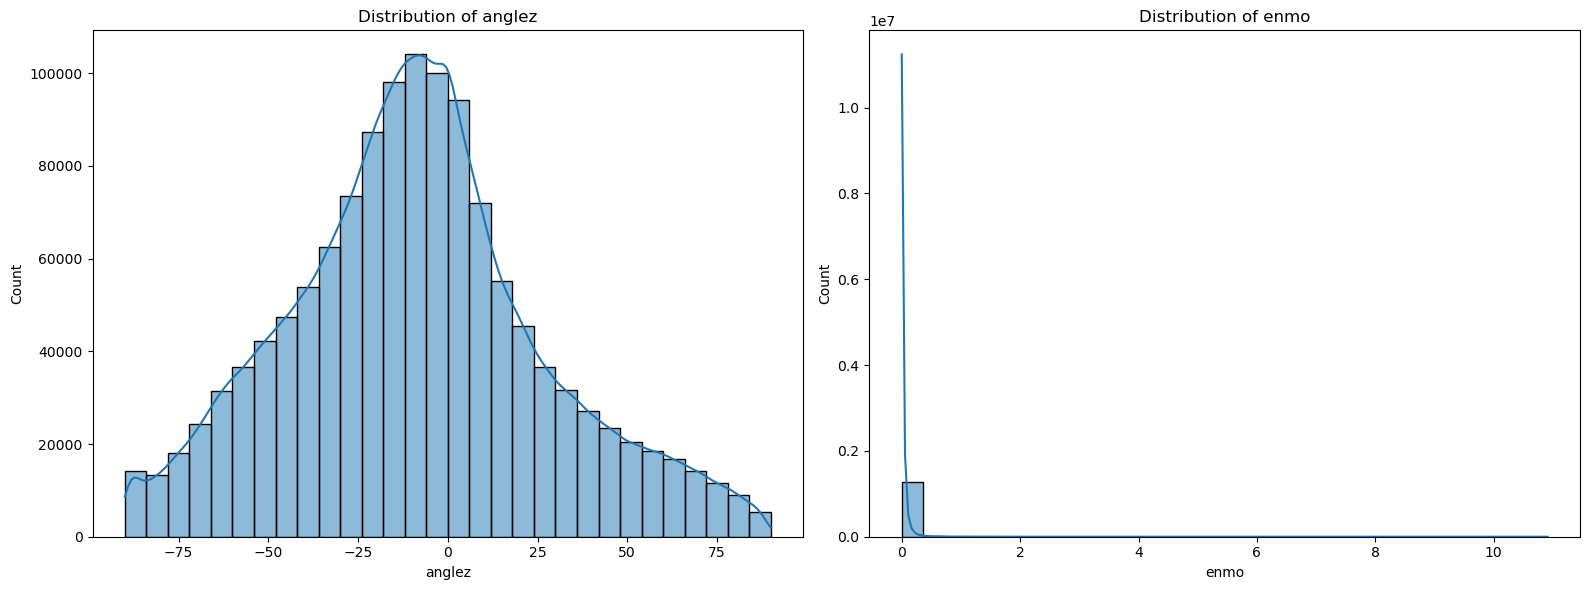

In [17]:
# Créer la figure avec deux sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution de 'anglez'
sns.histplot(train_series['anglez'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of anglez')

# Distribution de 'enmo'
sns.histplot(train_series['enmo'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of enmo')

# Ajuster l'affichage
plt.tight_layout()
plt.show()

La distribution de anglez suit un loi normal centrée sur 0. Les données semblent être normalisées.

La distribution de enmo semble par contre être uniquement centrée sur 0.

/tmp/ipykernel_221409/2360056554.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_series['timestamp'] = pd.to_datetime(subject_series['timestamp'])


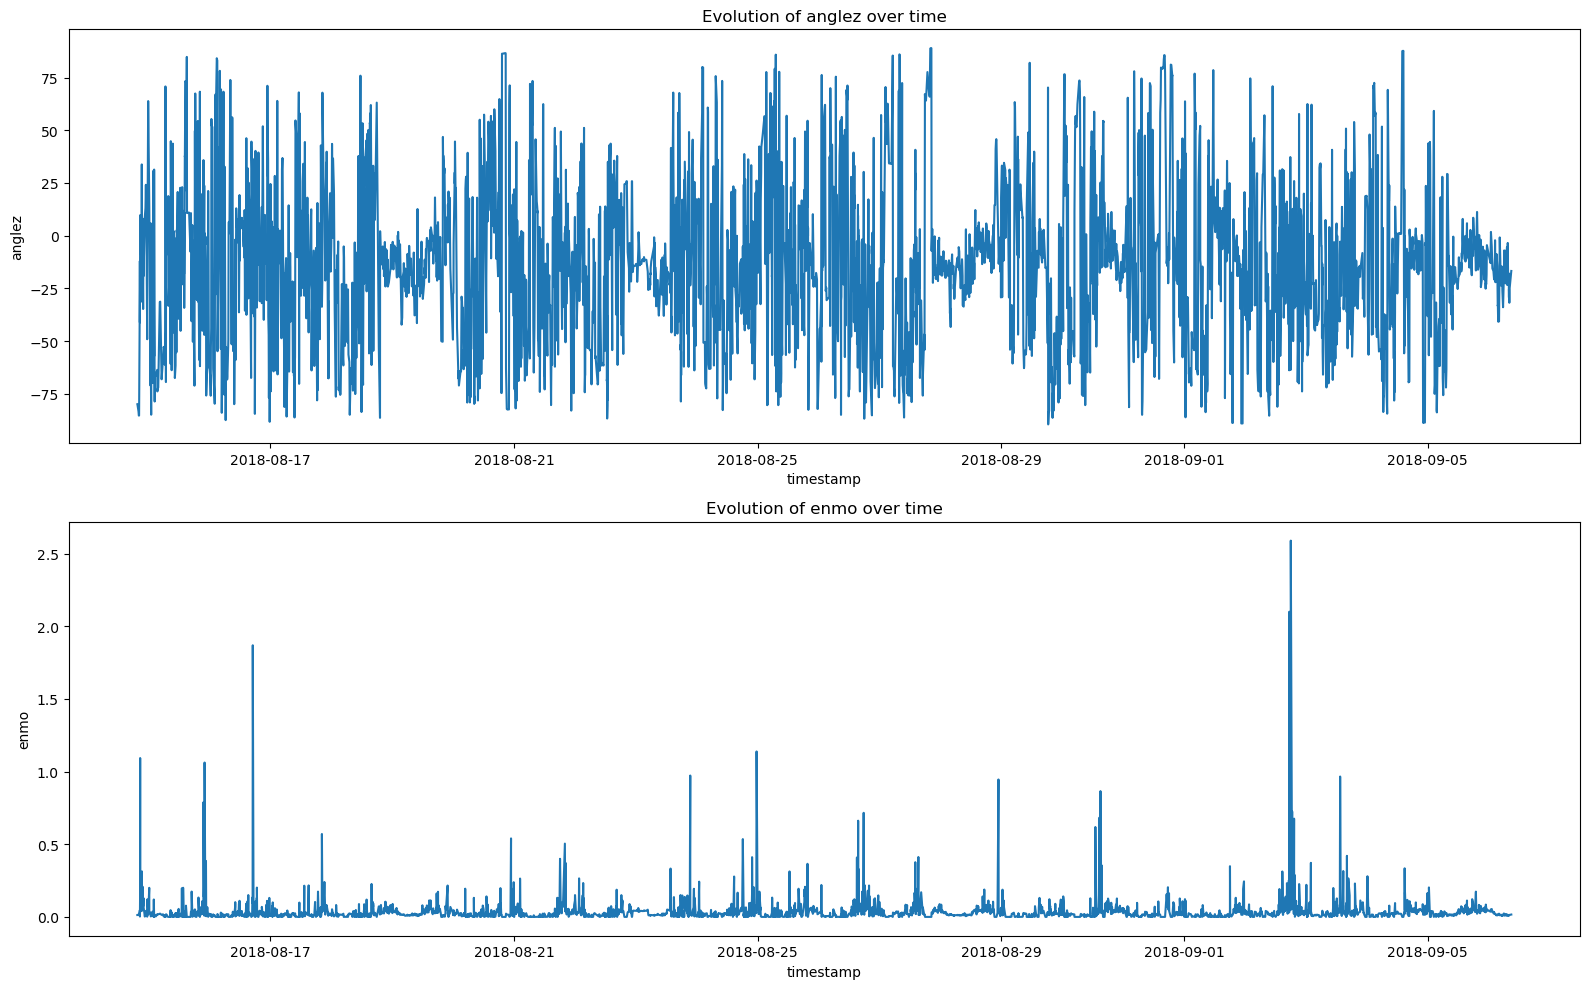

In [18]:
# Filtrer par un sujet spécifique (par exemple, le premier 'series_id')
subject_series = train_series[train_series['series_id'] == '038441c925bb']

# Convertir les timestamps en datetime si ce n'est pas déjà fait
subject_series['timestamp'] = pd.to_datetime(subject_series['timestamp'])

# Créer une figure avec deux sous-plots
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Visualiser 'anglez' en fonction du temps
sns.lineplot(x='timestamp', y='anglez', data=subject_series, ax=axes[0])
axes[0].set_title('Evolution of anglez over time')

# Visualiser 'enmo' en fonction du temps
sns.lineplot(x='timestamp', y='enmo', data=subject_series, ax=axes[1])
axes[1].set_title('Evolution of enmo over time')

# Ajuster l'affichage
plt.tight_layout()
plt.show()


Les valeurs d'angle z semblent suivre un cycle en fonction du temps. Probablement peu exprimé, donc exprimé uniformémement pendants les nuits et beaucoup exprimé pendant les journées. Ca peut laisser penser qu'il donne une information importante sur les phases jours/nuit (sommeil / eveil)

L'evolution de l'enmo (intensité de l'activité physique) montre pareil une fluctuation d'expression cyclique résumant les phases de sommeil (inactivité) et d'activité.

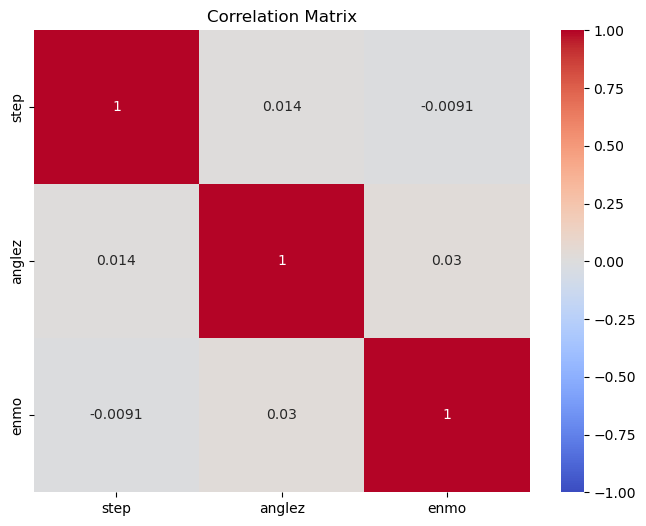

In [19]:
# Calculer la matrice de corrélation
corr_matrix = train_series[['step', 'anglez', 'enmo']].corr()

# Visualiser la matrice de corrélation avec une heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


IL n'y a pas de relation de correlation entre les données. Cela peut laisser penser que les features anglez (angle du bras) et enmo (activité physique) ne donnent pas la même information

Chaque variable semble donc apporter des informations distinctes et indépendantes les unes des autres.

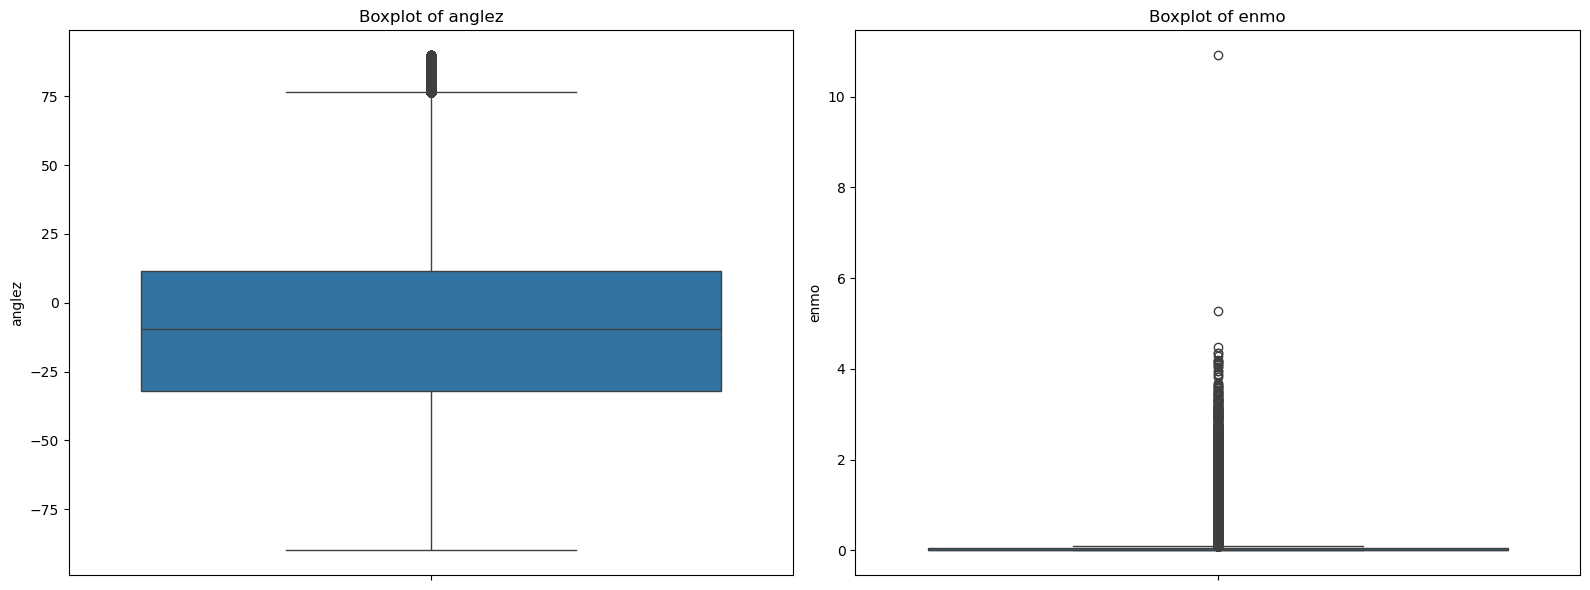

In [20]:
# Créer une figure avec deux sous-plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot pour 'anglez'
sns.boxplot(y=train_series['anglez'], ax=axes[0])
axes[0].set_title('Boxplot of anglez')

# Boxplot pour 'enmo'
sns.boxplot(y=train_series['enmo'], ax=axes[1])
axes[1].set_title('Boxplot of enmo')

# Ajuster l'affichage
plt.tight_layout()
plt.show()

On observe quelques outliers pour les valeurs de anglez. Sinon les données semblent être très bien distribuées.

Pour Enmo la majorité des valeurs sont concentrées sur 0. (Surement parce que la personne est inactive pendant le sommeil et qu'on filtré les valeurs selon les événements de sommeil)  
On detecte tout de même quelques outliers correspondant possiblement à des periodes d'activité de la personne (probablement les quelques données qui ne sont pas à évenement)  

Il y a un outlier qui ressort pour enmo, >10

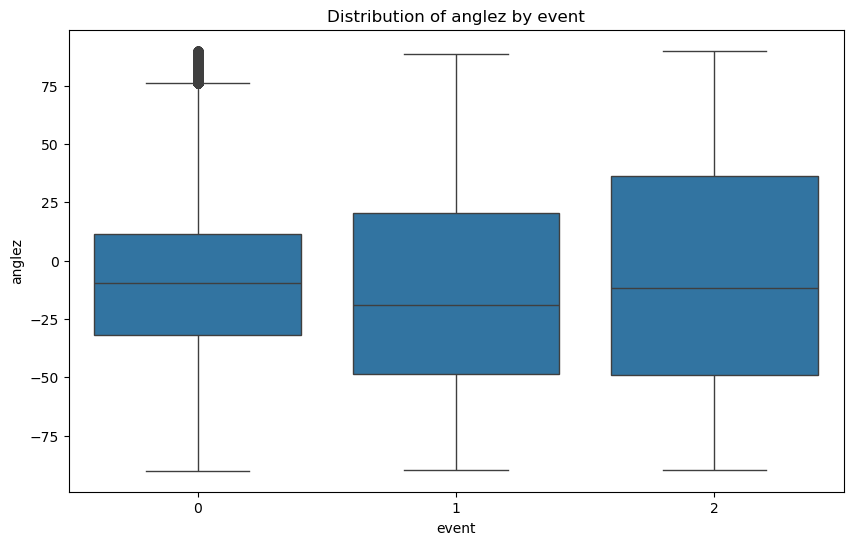

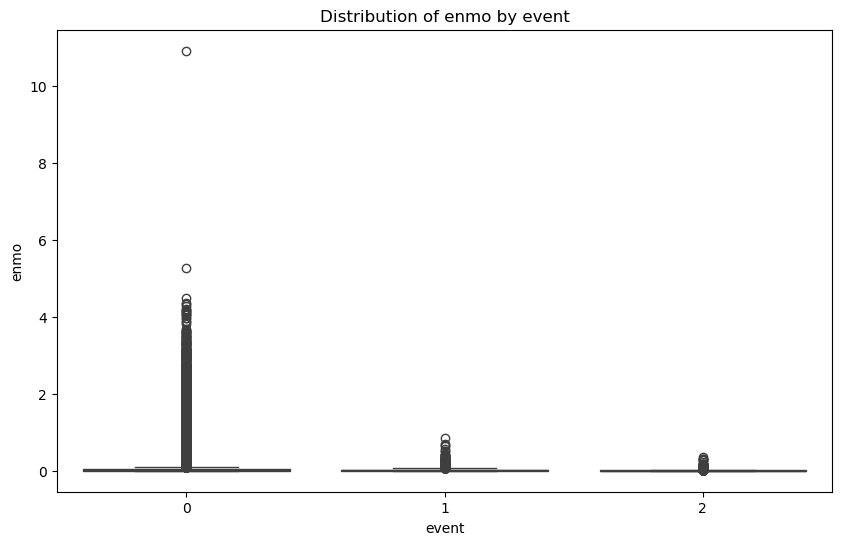

In [21]:
# Visualiser la distribution de 'anglez' en fonction de l'événement
plt.figure(figsize=(10, 6))
sns.boxplot(x='event', y='anglez', data=train_series)
plt.title('Distribution of anglez by event')
plt.show()

# Visualiser la distribution de 'enmo' en fonction de l'événement
plt.figure(figsize=(10, 6))
sns.boxplot(x='event', y='enmo', data=train_series)
plt.title('Distribution of enmo by event')
plt.show()


event = 0 période neutre  
event = 1 preiode onset  
event = 2 periode wakeup  

On remarque que pour anglez à l'event neutre, la mediane se situe un peu en dessous de 0 ce qui signifie que la majorité des observations ont un angle autour de cette valeur.  
On remarque que pour anglez à l'event onset, la mediane est plus basse et se situe autour de -25 ce qui signifie que le bras semble avoir une position plus inclinée ou stable au moment du début du sommeil.  
On remarque que pour anglez à l'event wakeup, la mediane est similaire à précédement mais les données couvrent une plus grande plage de données pouvant indiqué plus de mouvement du bras donc de l'activité.  
 
On remarque beaucoup d'outliers correspondant à la phase neutre (avec probablement de l'activité).  
Beaucoup moins pour la phase d'endormissement indiquant qu'il y une très grosse diminution de l'activité.  
De même pour la phase de réveil.  

In [29]:
# Filtrer les valeurs de 'enmo' supérieures à 10 pour identifier les outliers
outliers_enmo = train_series[train_series['enmo'] > 10]
outliers_enmo

,series_id,step,timestamp,anglez,enmo,event
369004,4a31811f3558,293242,2018-11-02 19:16:50+00:00,37.3696,10.9134,0


In [30]:
# Afficher les informations de l'outlier
print("Informations sur l'outlier de 'enmo' supérieur à 10 :")
print(outliers_enmo[['series_id', 'timestamp', 'anglez', 'enmo']])

Informations sur l'outlier de 'enmo' supérieur à 10 :
           series_id                  timestamp   anglez     enmo
369004  4a31811f3558  2018-11-02 19:16:50+00:00  37.3696  10.9134


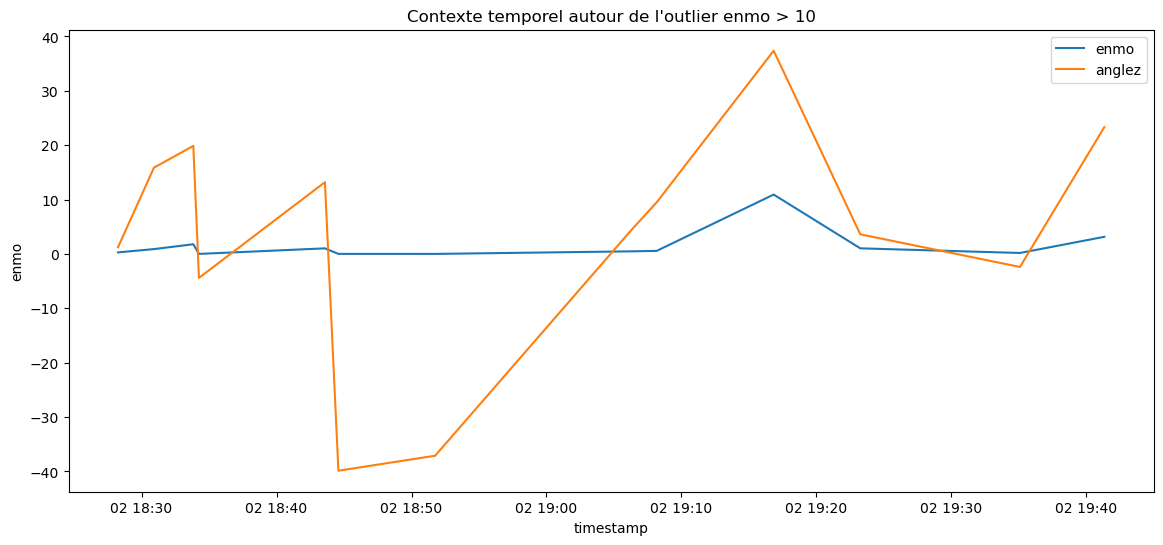

In [38]:
# Conversion de la colonne 'timestamp' en datetime
train_series['timestamp'] = pd.to_datetime(train_series['timestamp'], errors='coerce')

# Filtrer les valeurs de 'enmo' supérieures à 10 pour identifier les outliers
outliers_enmo = train_series[train_series['enmo'] > 10]

# Rechercher le timestamp et series_id de l'outlier
outlier_timestamp = outliers_enmo.iloc[0]['timestamp']  # Timestamp de l'outlier
series_id_outlier = outliers_enmo.iloc[0]['series_id']  # Series ID de l'outlier

# Filtrer pour une plage temporelle autour de cet outlier
context_data = train_series[
    (train_series['series_id'] == series_id_outlier) &
    (train_series['timestamp'] >= outlier_timestamp - pd.Timedelta(minutes=60)) &
    (train_series['timestamp'] <= outlier_timestamp + pd.Timedelta(minutes=60))
]

# Visualiser 'enmo' et 'anglez' autour de cet outlier
plt.figure(figsize=(14, 6))
sns.lineplot(x='timestamp', y='enmo', data=context_data, label='enmo')
sns.lineplot(x='timestamp', y='anglez', data=context_data, label='anglez')
plt.title('Contexte temporel autour de l\'outlier enmo > 10')
plt.legend()
plt.show()




### Test series visualization

In [18]:
test_series

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215
...,...,...,...,...,...
445,0402a003dae9,145,2018-12-18T12:57:05-0500,-59.696899,0.0601
446,0402a003dae9,146,2018-12-18T12:57:10-0500,-35.656601,0.0427
447,0402a003dae9,147,2018-12-18T12:57:15-0500,-21.582399,0.0309
448,0402a003dae9,148,2018-12-18T12:57:20-0500,-42.616001,0.0328


In [19]:
# Calculer le nombre de valeurs NaN par colonne
nan_counts = test_series.isna().sum()

# Afficher le résultat
print(f"Nombre de valeurs manquantes par colones:\n{nan_counts}")

Nombre de valeurs manquantes par colones:
series_id    0
step         0
timestamp    0
anglez       0
enmo         0
dtype: int64


In [20]:
num_duplicates = test_series.duplicated().sum()
print(f"Nombre de lignes dupliquées : {num_duplicates}")

Nombre de lignes dupliquées : 0


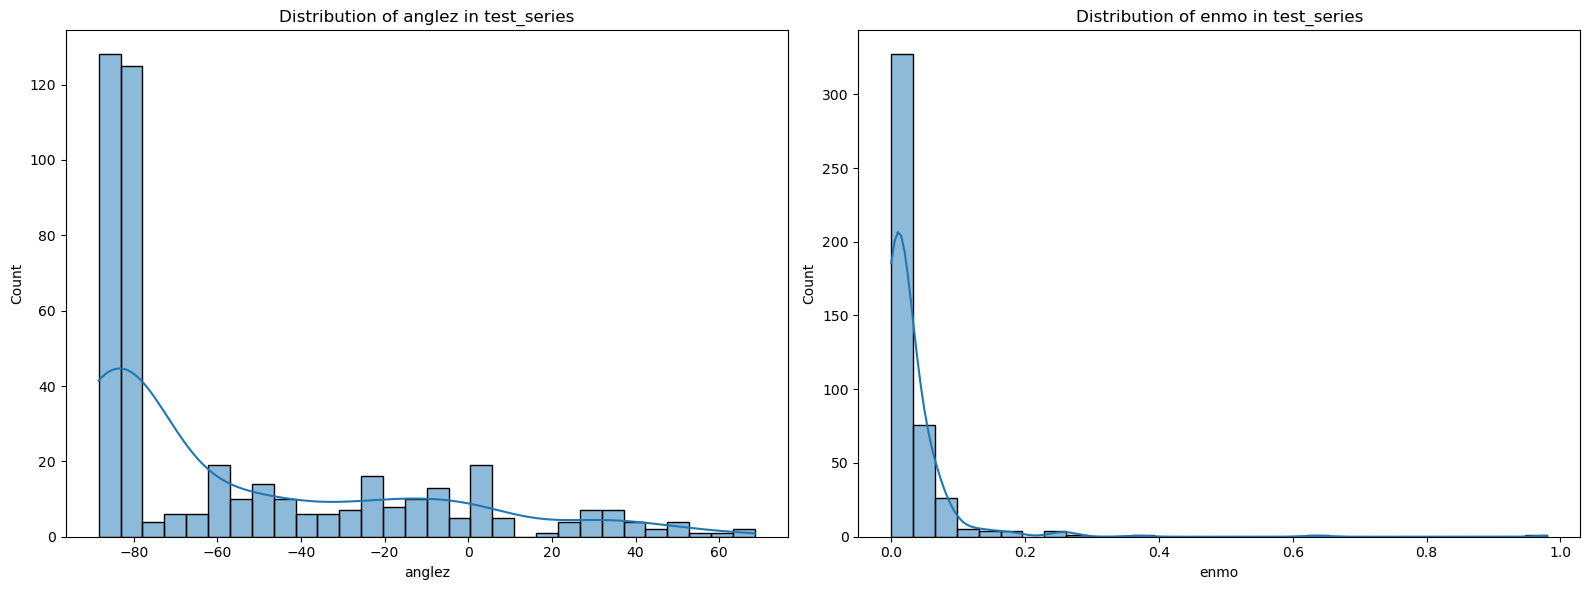

In [22]:
# Visualisation des distributions de 'anglez' et 'enmo' dans test_series
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution de 'anglez'
sns.histplot(test_series['anglez'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of anglez in test_series')

# Distribution de 'enmo'
sns.histplot(test_series['enmo'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of enmo in test_series')

plt.tight_layout()
plt.show()


On peut voir un pic d'angles autour de -80° Cela peut représenter une stabilité du bras à cet angle. Il y a quelques valeurs après 0° mais ça reste peu. La conformation normale du bras semble donc être négative.  

La distribution de enmo montre un pic d'activité autour de 0 indiquant une très trè_s légère activité physique (indiquant phase de onset/wakeup)

==> La majorité des valeurs de test semblent donc être concentrées sur des phases de sommeil ou d'endormissement

/tmp/ipykernel_29377/4127353582.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_test_series['timestamp'] = pd.to_datetime(subject_test_series['timestamp'])


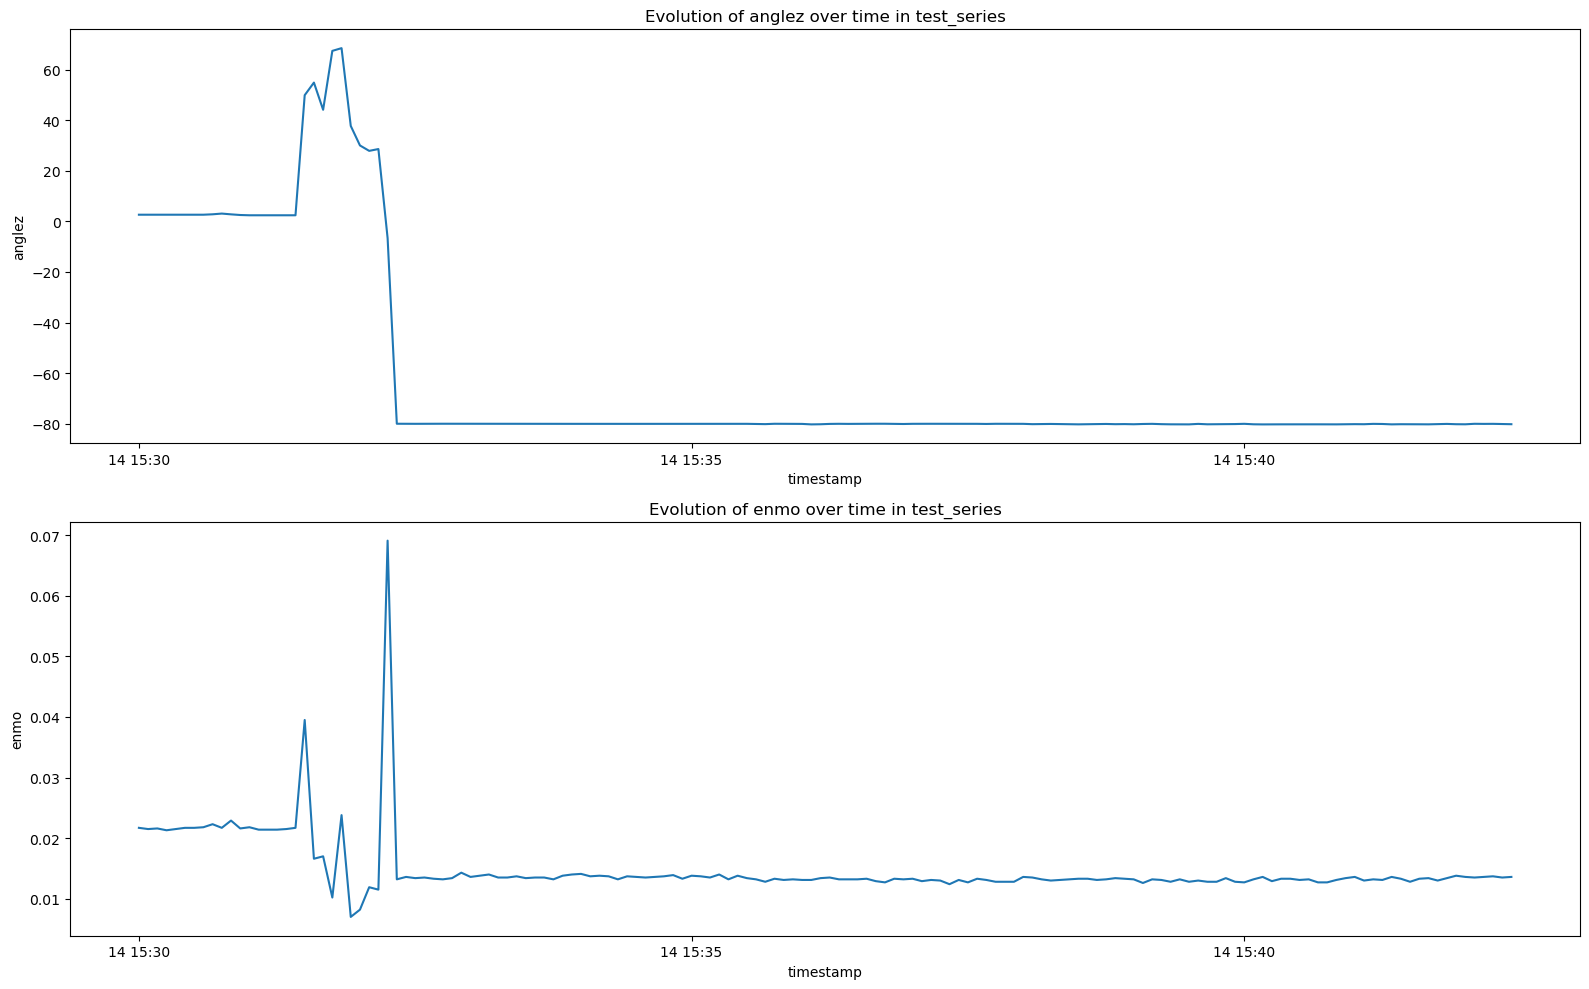

In [24]:
# Filtrer par un sujet spécifique dans test_series
subject_test_series = test_series[test_series['series_id'] == '038441c925bb']

# Convertir les timestamps en datetime si nécessaire
subject_test_series['timestamp'] = pd.to_datetime(subject_test_series['timestamp'])

# Visualisation de l'évolution de 'anglez' et 'enmo' dans le temps
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

sns.lineplot(x='timestamp', y='anglez', data=subject_test_series, ax=axes[0])
axes[0].set_title('Evolution of anglez over time in test_series')

sns.lineplot(x='timestamp', y='enmo', data=subject_test_series, ax=axes[1])
axes[1].set_title('Evolution of enmo over time in test_series')

plt.tight_layout()
plt.show()


Pour ce sujet, il semble avoir un changement soudain de l'angle du bras et une chute à un angle de 80° qui se stabilise ensuite. Probablement un mouvement du bras pendant le sommeil ? 

On observe la même chose pour le enmo.

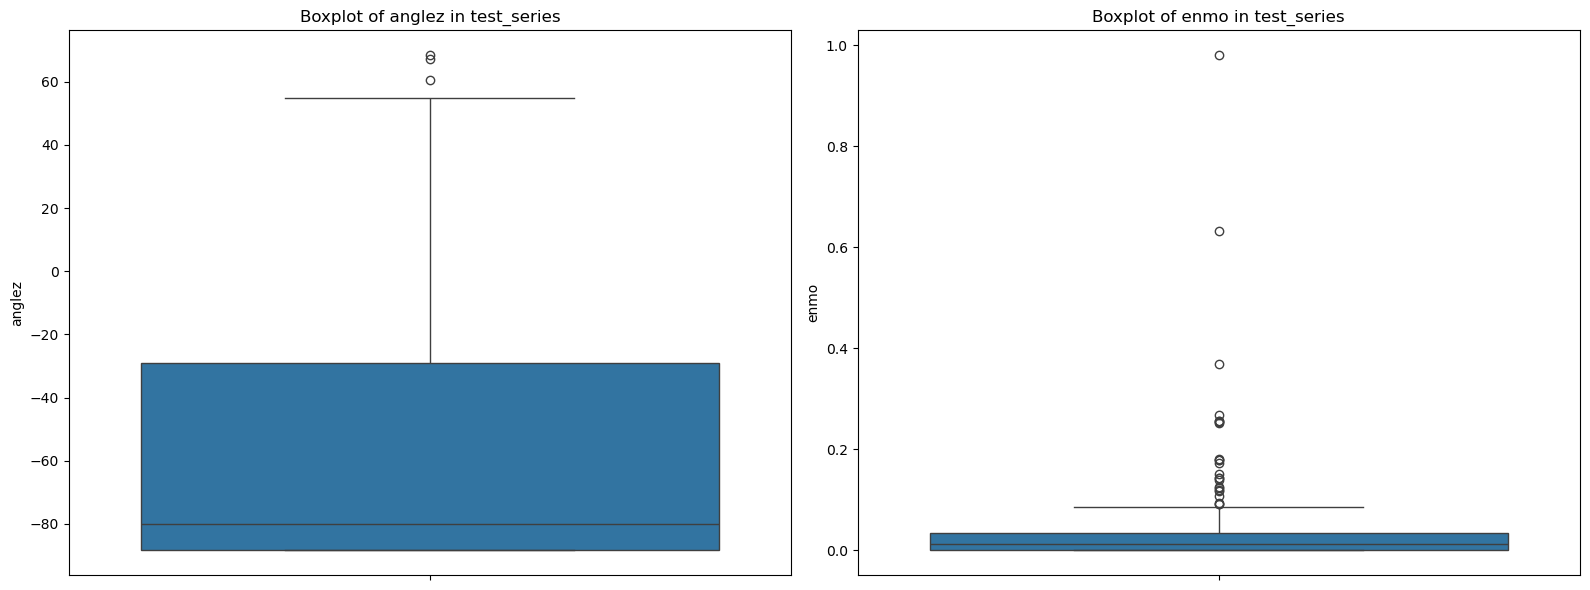

In [25]:
# Visualisation des boxplots pour 'anglez' et 'enmo' dans test_series
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(y='anglez', data=test_series, ax=axes[0])
axes[0].set_title('Boxplot of anglez in test_series')

sns.boxplot(y='enmo', data=test_series, ax=axes[1])
axes[1].set_title('Boxplot of enmo in test_series')

plt.tight_layout()
plt.show()


On voit la médiane à -80° correspondant à une positon inclinée et stable du bras.
Il y a quelques outliers correspondant porbablement à un repositionnement du bras.

L'activité est très faible et la médiane pratiquement centrée sur 0. O remarque aussi quelques outliers correspondants probablement à du mouvement.

Au final ces données tests correspondent majoritairement à des phases stables sans activité.. On remarque tout de même quelques périodes d'activités pouvant possiblement correspondre à des changements de position ou des phases de réveil.

Elles sont similaires avec les données d'entraînement